# Posture Recognition Dataset Exploration

This notebook explores the posture dataset and provides insights for model training.

In [2]:
import sys
import os
sys.path.append('../src')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import cv2
from collections import Counter

# Import our preprocessing functions
from preprocess import prepare_data, visualize_samples

# Set style for better plots
plt.style.use('default')
sns.set_palette('husl')

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Dataset Overview

In [3]:
# Load the dataset
DATA_DIR = "../data"
X_train, X_val, y_train, y_val, class_names = prepare_data(data_dir=DATA_DIR)

print(f"Dataset Summary:")
print(f"- Total training samples: {len(X_train)}")
print(f"- Total validation samples: {len(X_val)}")
print(f"- Image shape: {X_train[0].shape}")
print(f"- Number of classes: {len(class_names)}")
print(f"- Class names: {class_names}")

Loading and preparing dataset...
Dataset loaded: 100 images, 2 classes
Training samples: 80
Validation samples: 20
Dataset Summary:
- Total training samples: 80
- Total validation samples: 20
- Image shape: (224, 224, 3)
- Number of classes: 2
- Class names: ['correct', 'incorrect']


## 2. Class Distribution

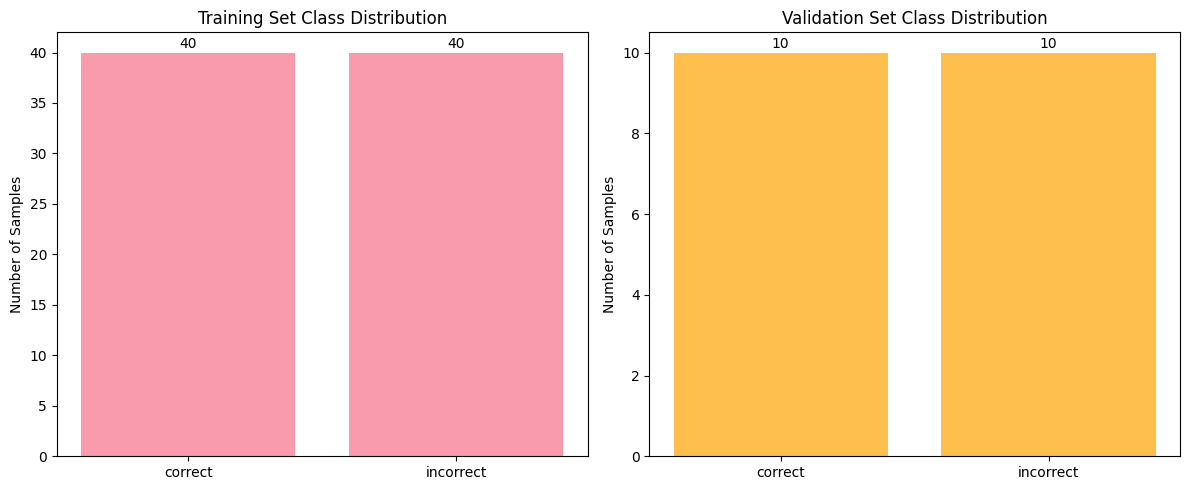

correct: 40 samples (50.0%)
incorrect: 40 samples (50.0%)


In [4]:
# Analyze class distribution
train_labels = np.argmax(y_train, axis=1)
val_labels = np.argmax(y_val, axis=1)

train_counts = Counter(train_labels)
val_counts = Counter(val_labels)

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Training set distribution
classes = [class_names[i] for i in range(len(class_names))]
train_values = [train_counts[i] for i in range(len(class_names))]
ax1.bar(classes, train_values, alpha=0.7)
ax1.set_title('Training Set Class Distribution')
ax1.set_ylabel('Number of Samples')
for i, v in enumerate(train_values):
    ax1.text(i, v + max(train_values)*0.01, str(v), ha='center')

# Validation set distribution
val_values = [val_counts[i] for i in range(len(class_names))]
ax2.bar(classes, val_values, alpha=0.7, color='orange')
ax2.set_title('Validation Set Class Distribution')
ax2.set_ylabel('Number of Samples')
for i, v in enumerate(val_values):
    ax2.text(i, v + max(val_values)*0.01, str(v), ha='center')

plt.tight_layout()
plt.show()

# Check for class imbalance
total_train = sum(train_values)
for i, (class_name, count) in enumerate(zip(classes, train_values)):
    percentage = (count / total_train) * 100
    print(f"{class_name}: {count} samples ({percentage:.1f}%)")

## 3. Sample Images Visualization

Sample images from the dataset:


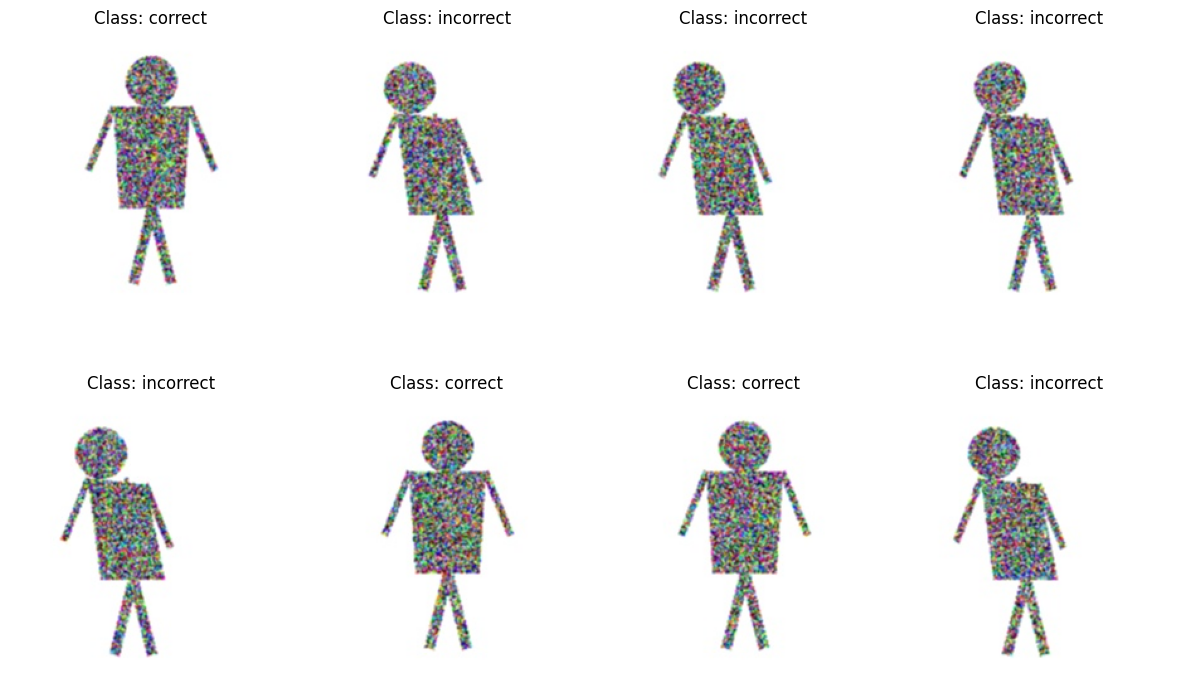

In [5]:
# Visualize sample images from each class
print("Sample images from the dataset:")
visualize_samples(X_train, y_train, class_names, num_samples=8)

## 4. Image Statistics Analysis

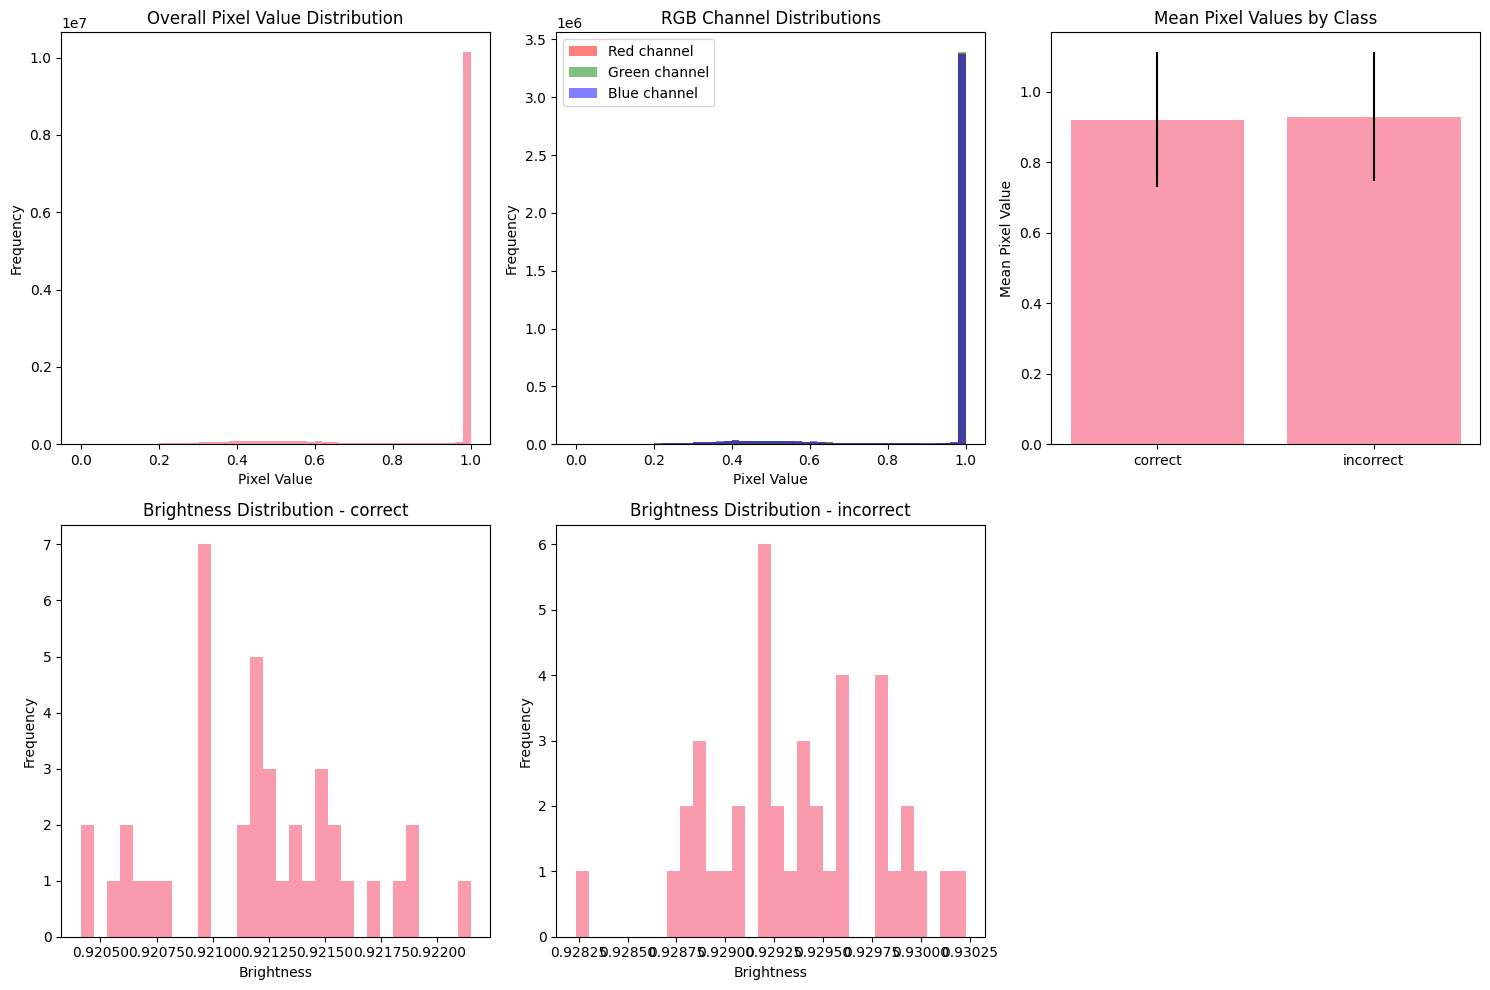


Dataset Statistics:
Overall mean pixel value: 0.925
Overall std pixel value: 0.188
Min pixel value: 0.000
Max pixel value: 1.000


In [6]:
# Analyze pixel value distributions
def analyze_image_statistics(images, labels, class_names):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Overall pixel distribution
    all_pixels = images.flatten()
    axes[0, 0].hist(all_pixels, bins=50, alpha=0.7)
    axes[0, 0].set_title('Overall Pixel Value Distribution')
    axes[0, 0].set_xlabel('Pixel Value')
    axes[0, 0].set_ylabel('Frequency')
    
    # RGB channel distributions
    colors = ['red', 'green', 'blue']
    for i, color in enumerate(colors):
        channel_pixels = images[:, :, :, i].flatten()
        axes[0, 1].hist(channel_pixels, bins=50, alpha=0.5, label=f'{color.title()} channel', color=color)
    axes[0, 1].set_title('RGB Channel Distributions')
    axes[0, 1].set_xlabel('Pixel Value')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].legend()
    
    # Mean pixel values per class
    class_means = []
    class_stds = []
    
    for class_idx in range(len(class_names)):
        class_mask = np.argmax(labels, axis=1) == class_idx
        class_images = images[class_mask]
        
        if len(class_images) > 0:
            mean_val = np.mean(class_images)
            std_val = np.std(class_images)
            class_means.append(mean_val)
            class_stds.append(std_val)
        else:
            class_means.append(0)
            class_stds.append(0)
    
    axes[0, 2].bar(class_names, class_means, yerr=class_stds, alpha=0.7)
    axes[0, 2].set_title('Mean Pixel Values by Class')
    axes[0, 2].set_ylabel('Mean Pixel Value')
    
    # Brightness distribution per class
    for class_idx in range(len(class_names)):
        class_mask = np.argmax(labels, axis=1) == class_idx
        class_images = images[class_mask]
        
        if len(class_images) > 0:
            # Calculate brightness (mean of RGB values)
            brightness = np.mean(class_images, axis=(1, 2, 3))
            axes[1, class_idx].hist(brightness, bins=30, alpha=0.7)
            axes[1, class_idx].set_title(f'Brightness Distribution - {class_names[class_idx]}')
            axes[1, class_idx].set_xlabel('Brightness')
            axes[1, class_idx].set_ylabel('Frequency')
    
    # If we have less than 3 classes, hide the extra subplot
    if len(class_names) < 3:
        axes[1, 2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print("\nDataset Statistics:")
    print(f"Overall mean pixel value: {np.mean(all_pixels):.3f}")
    print(f"Overall std pixel value: {np.std(all_pixels):.3f}")
    print(f"Min pixel value: {np.min(all_pixels):.3f}")
    print(f"Max pixel value: {np.max(all_pixels):.3f}")

analyze_image_statistics(X_train, y_train, class_names)

## 5. Data Augmentation Preview


Augmentation examples for correct class:


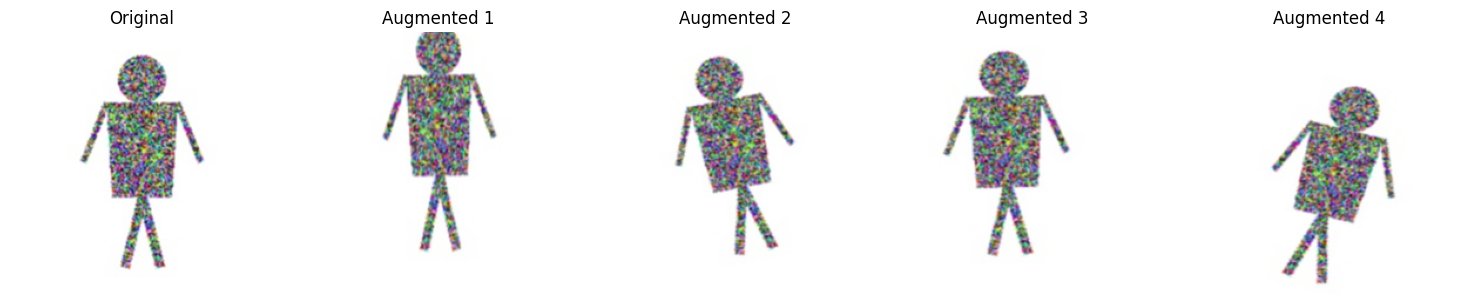


Augmentation examples for incorrect class:


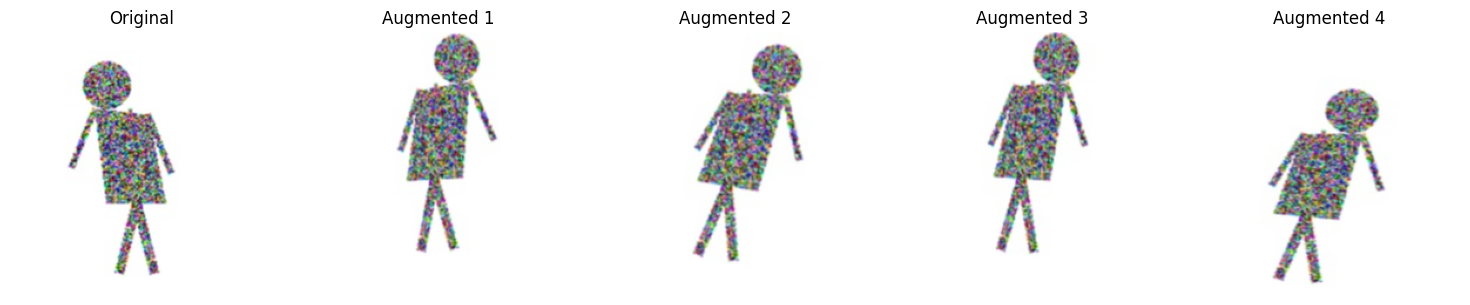

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create augmentation generator
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Show original vs augmented images
def show_augmentation_examples(image, num_examples=4):
    fig, axes = plt.subplots(1, num_examples + 1, figsize=(15, 3))
    
    # Original image
    axes[0].imshow(image)
    axes[0].set_title('Original')
    axes[0].axis('off')
    
    # Augmented images
    image_batch = np.expand_dims(image, axis=0)
    augmented_iter = datagen.flow(image_batch, batch_size=1)
    
    for i in range(num_examples):
        augmented_image = next(augmented_iter)[0]
        # Ensure values are in [0, 1] range for display
        augmented_image = np.clip(augmented_image, 0, 1)
        
        axes[i + 1].imshow(augmented_image)
        axes[i + 1].set_title(f'Augmented {i + 1}')
        axes[i + 1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Show augmentation examples for different classes
for class_idx in range(len(class_names)):
    class_mask = np.argmax(y_train, axis=1) == class_idx
    class_images = X_train[class_mask]
    
    if len(class_images) > 0:
        print(f"\nAugmentation examples for {class_names[class_idx]} class:")
        show_augmentation_examples(class_images[0])

## 6. Dataset Quality Assessment

In [8]:
def assess_dataset_quality(images, labels, class_names):
    print("Dataset Quality Assessment:")
    print("=" * 50)
    
    # 1. Check for data leakage (identical images)
    print("\n1. Checking for duplicate images...")
    image_hashes = []
    for img in images:
        # Simple hash based on mean values
        img_hash = hash(tuple(img.flatten()[:100]))  # Use first 100 pixels for speed
        image_hashes.append(img_hash)
    
    unique_hashes = len(set(image_hashes))
    total_images = len(image_hashes)
    duplicate_count = total_images - unique_hashes
    
    print(f"   - Total images: {total_images}")
    print(f"   - Unique images: {unique_hashes}")
    print(f"   - Potential duplicates: {duplicate_count}")
    if duplicate_count > 0:
        print("   ⚠️  Warning: Potential duplicate images detected")
    else:
        print("   ✅ No duplicate images detected")
    
    # 2. Check image quality metrics
    print("\n2. Image quality metrics...")
    
    # Calculate contrast and sharpness
    contrasts = []
    sharpness_scores = []
    
    for img in images[:100]:  # Sample first 100 for speed
        # Convert to grayscale for analysis
        gray = np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])
        
        # Contrast (standard deviation of pixel values)
        contrast = np.std(gray)
        contrasts.append(contrast)
        
        # Sharpness (variance of Laplacian)
        laplacian_var = cv2.Laplacian((gray * 255).astype(np.uint8), cv2.CV_64F).var()
        sharpness_scores.append(laplacian_var)
    
    print(f"   - Average contrast: {np.mean(contrasts):.3f} ± {np.std(contrasts):.3f}")
    print(f"   - Average sharpness: {np.mean(sharpness_scores):.1f} ± {np.std(sharpness_scores):.1f}")
    
    # Quality thresholds (these are rough guidelines)
    low_contrast_threshold = 0.05
    low_sharpness_threshold = 100
    
    low_contrast_count = sum(1 for c in contrasts if c < low_contrast_threshold)
    low_sharpness_count = sum(1 for s in sharpness_scores if s < low_sharpness_threshold)
    
    if low_contrast_count > len(contrasts) * 0.1:
        print(f"   ⚠️  Warning: {low_contrast_count} images have low contrast")
    if low_sharpness_count > len(sharpness_scores) * 0.1:
        print(f"   ⚠️  Warning: {low_sharpness_count} images may be blurry")
    
    # 3. Class balance analysis
    print("\n3. Class balance analysis...")
    label_counts = []
    for class_idx in range(len(class_names)):
        count = np.sum(np.argmax(labels, axis=1) == class_idx)
        label_counts.append(count)
    
    min_count = min(label_counts)
    max_count = max(label_counts)
    imbalance_ratio = max_count / min_count if min_count > 0 else float('inf')
    
    print(f"   - Imbalance ratio: {imbalance_ratio:.2f}")
    if imbalance_ratio > 3:
        print("   ⚠️  Warning: Significant class imbalance detected")
        print("   💡 Consider using class weights or resampling techniques")
    else:
        print("   ✅ Classes are reasonably balanced")
    
    # 4. Recommendations
    print("\n4. Recommendations:")
    if total_images < 1000:
        print("   📈 Consider collecting more data for better performance")
    if duplicate_count > 0:
        print("   🔍 Remove duplicate images to prevent overfitting")
    if imbalance_ratio > 3:
        print("   ⚖️  Address class imbalance with weighted loss or data augmentation")
    
    print("\n" + "=" * 50)

assess_dataset_quality(X_train, y_train, class_names)

Dataset Quality Assessment:

1. Checking for duplicate images...
   - Total images: 80
   - Unique images: 1
   - Potential duplicates: 79
   ⚠️  Warning: Potential duplicate images detected

2. Image quality metrics...
   - Average contrast: 0.186 ± 0.005
   - Average sharpness: 454.3 ± 22.6

3. Class balance analysis...
   - Imbalance ratio: 1.00
   ✅ Classes are reasonably balanced

4. Recommendations:
   📈 Consider collecting more data for better performance
   🔍 Remove duplicate images to prevent overfitting



## 7. Correlation Analysis

Class Separability Analysis:


C:\Users\William Rudwall\AppData\Local\Temp\ipykernel_312\590101894.py:39: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot(data_by_class, labels=class_names)
C:\Users\William Rudwall\AppData\Local\Temp\ipykernel_312\590101894.py:39: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot(data_by_class, labels=class_names)
C:\Users\William Rudwall\AppData\Local\Temp\ipykernel_312\590101894.py:39: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot(data_by_class, labels=class_names)
C:\Users\William Rudwall\AppData\Local\Temp\ipykernel_312\590101894.py:39: MatplotlibDeprecationWarning: The 

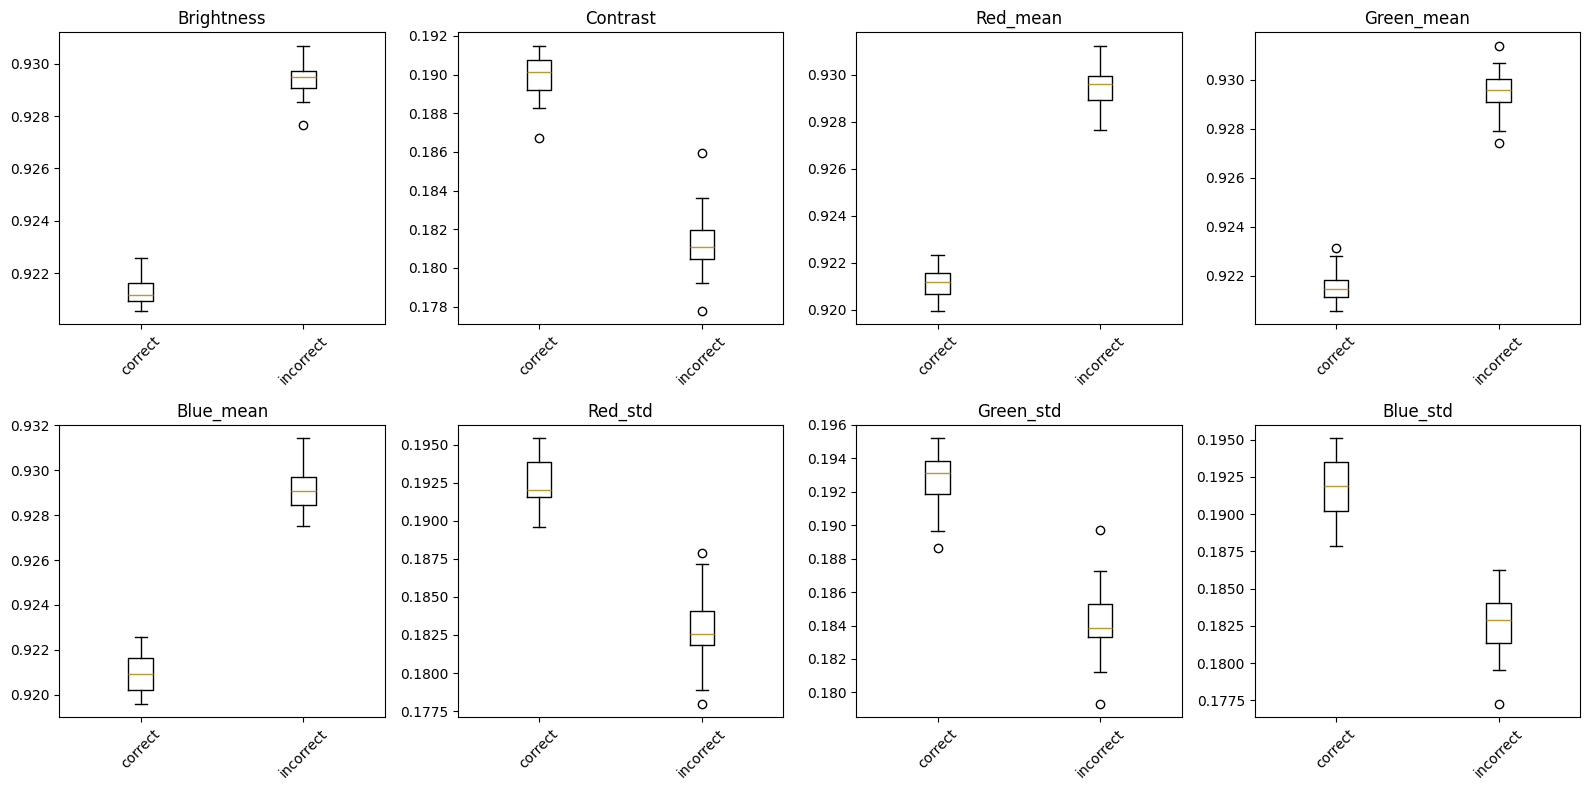


Feature separability scores:
   Brightness: 0.0081
   Contrast: 0.0088
   Red_mean: 0.0083
   Green_mean: 0.0080
   Blue_mean: 0.0082
   Red_std: 0.0095
   Green_std: 0.0087
   Blue_std: 0.0091


In [9]:
# Analyze feature correlations between classes
def analyze_class_separability(images, labels, class_names):
    print("Class Separability Analysis:")
    print("=" * 40)
    
    # Extract simple features for each image
    features = []
    for img in images:
        # Calculate various statistical features
        gray = np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])
        
        feature_vector = [
            np.mean(gray),           # Average brightness
            np.std(gray),            # Contrast
            np.mean(img[:, :, 0]),   # Red channel mean
            np.mean(img[:, :, 1]),   # Green channel mean
            np.mean(img[:, :, 2]),   # Blue channel mean
            np.std(img[:, :, 0]),    # Red channel std
            np.std(img[:, :, 1]),    # Green channel std
            np.std(img[:, :, 2]),    # Blue channel std
        ]
        features.append(feature_vector)
    
    features = np.array(features)
    feature_names = ['Brightness', 'Contrast', 'Red_mean', 'Green_mean', 'Blue_mean',
                    'Red_std', 'Green_std', 'Blue_std']
    
    # Create box plots for each feature by class
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    for i, feature_name in enumerate(feature_names):
        data_by_class = []
        for class_idx in range(len(class_names)):
            class_mask = np.argmax(labels, axis=1) == class_idx
            class_features = features[class_mask, i]
            data_by_class.append(class_features)
        
        axes[i].boxplot(data_by_class, labels=class_names)
        axes[i].set_title(feature_name)
        axes[i].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate feature importance (simple difference between class means)
    print("\nFeature separability scores:")
    for i, feature_name in enumerate(feature_names):
        class_means = []
        for class_idx in range(len(class_names)):
            class_mask = np.argmax(labels, axis=1) == class_idx
            class_mean = np.mean(features[class_mask, i])
            class_means.append(class_mean)
        
        # Calculate separability as difference between class means
        separability = abs(class_means[0] - class_means[1]) if len(class_means) >= 2 else 0
        print(f"   {feature_name}: {separability:.4f}")

analyze_class_separability(X_train, y_train, class_names)

## 8. Training Recommendations

In [10]:
def generate_training_recommendations(X_train, X_val, y_train, y_val, class_names):
    print("Training Recommendations:")
    print("=" * 50)
    
    total_samples = len(X_train) + len(X_val)
    train_ratio = len(X_train) / total_samples
    
    print(f"\n📊 Dataset Size: {total_samples} total samples")
    print(f"   - Training: {len(X_train)} ({train_ratio:.1%})")
    print(f"   - Validation: {len(X_val)} ({1-train_ratio:.1%})")
    
    # Batch size recommendations
    print(f"\n⚙️  Recommended Training Parameters:")
    
    if total_samples < 500:
        print(f"   - Batch size: 16-32 (small dataset)")
        print(f"   - Epochs: 50-100 (more epochs for small data)")
        print(f"   - Learning rate: 0.001-0.01")
    elif total_samples < 2000:
        print(f"   - Batch size: 32-64")
        print(f"   - Epochs: 30-50")
        print(f"   - Learning rate: 0.001")
    else:
        print(f"   - Batch size: 64-128")
        print(f"   - Epochs: 20-30")
        print(f"   - Learning rate: 0.001")
    
    # Data augmentation recommendations
    print(f"\n🔄 Data Augmentation:")
    if total_samples < 1000:
        print(f"   - Use aggressive augmentation")
        print(f"   - Rotation: ±20°, shifts: ±15%, zoom: ±15%")
    else:
        print(f"   - Use moderate augmentation")
        print(f"   - Rotation: ±15°, shifts: ±10%, zoom: ±10%")
    
    # Architecture recommendations
    print(f"\n🏗️  Model Architecture:")
    if total_samples < 500:
        print(f"   - Use smaller model (MobileNetV2 with fewer layers)")
        print(f"   - Add more dropout (0.5-0.7)")
        print(f"   - Consider transfer learning with frozen layers")
    else:
        print(f"   - MobileNetV2 or EfficientNet-B0 recommended")
        print(f"   - Standard dropout (0.3-0.5)")
        print(f"   - Fine-tuning after initial training")
    
    # Monitoring recommendations
    print(f"\n📈 Training Monitoring:")
    print(f"   - Use early stopping (patience: 10-15)")
    print(f"   - Monitor validation accuracy")
    print(f"   - Save best model checkpoints")
    print(f"   - Use learning rate reduction on plateau")
    
    # Expected performance
    print(f"\n🎯 Expected Performance:")
    if total_samples < 500:
        print(f"   - Target accuracy: 70-85%")
        print(f"   - Risk of overfitting: High")
    elif total_samples < 2000:
        print(f"   - Target accuracy: 80-90%")
        print(f"   - Risk of overfitting: Medium")
    else:
        print(f"   - Target accuracy: 85-95%")
        print(f"   - Risk of overfitting: Low")
    
    print(f"\n" + "=" * 50)

generate_training_recommendations(X_train, X_val, y_train, y_val, class_names)

Training Recommendations:

📊 Dataset Size: 100 total samples
   - Training: 80 (80.0%)
   - Validation: 20 (20.0%)

⚙️  Recommended Training Parameters:
   - Batch size: 16-32 (small dataset)
   - Epochs: 50-100 (more epochs for small data)
   - Learning rate: 0.001-0.01

🔄 Data Augmentation:
   - Use aggressive augmentation
   - Rotation: ±20°, shifts: ±15%, zoom: ±15%

🏗️  Model Architecture:
   - Use smaller model (MobileNetV2 with fewer layers)
   - Add more dropout (0.5-0.7)
   - Consider transfer learning with frozen layers

📈 Training Monitoring:
   - Use early stopping (patience: 10-15)
   - Monitor validation accuracy
   - Save best model checkpoints
   - Use learning rate reduction on plateau

🎯 Expected Performance:
   - Target accuracy: 70-85%
   - Risk of overfitting: High



## 9. Summary and Next Steps

In [11]:
print("Dataset Exploration Complete!")
print("=" * 40)
print("\n✅ Analysis completed:")
print("   - Dataset overview and statistics")
print("   - Class distribution analysis")
print("   - Image quality assessment")
print("   - Data augmentation preview")
print("   - Feature separability analysis")
print("   - Training recommendations")

print("\n🚀 Next steps:")
print("   1. Review the recommendations above")
print("   2. Adjust training parameters in train.py if needed")
print("   3. Run the training script: python ../src/train.py")
print("   4. Monitor training progress and metrics")
print("   5. Test the model with inference.py")

print("\n📝 Notes:")
print("   - This notebook analyzed your current dataset")
print("   - Recommendations are based on dataset size and quality")
print("   - Monitor validation metrics during training")
print("   - Adjust hyperparameters based on initial results")

Dataset Exploration Complete!

✅ Analysis completed:
   - Dataset overview and statistics
   - Class distribution analysis
   - Image quality assessment
   - Data augmentation preview
   - Feature separability analysis
   - Training recommendations

🚀 Next steps:
   1. Review the recommendations above
   2. Adjust training parameters in train.py if needed
   3. Run the training script: python ../src/train.py
   4. Monitor training progress and metrics
   5. Test the model with inference.py

📝 Notes:
   - This notebook analyzed your current dataset
   - Recommendations are based on dataset size and quality
   - Monitor validation metrics during training
   - Adjust hyperparameters based on initial results
